In [31]:
# dependency imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## 2. Collect the data

In [32]:
# Read in AMZN historical stock data as `data`
filepath = "../historical_data/AMZN.csv"
data = pd.read_csv(filepath)

# print(data)
# data.describe()

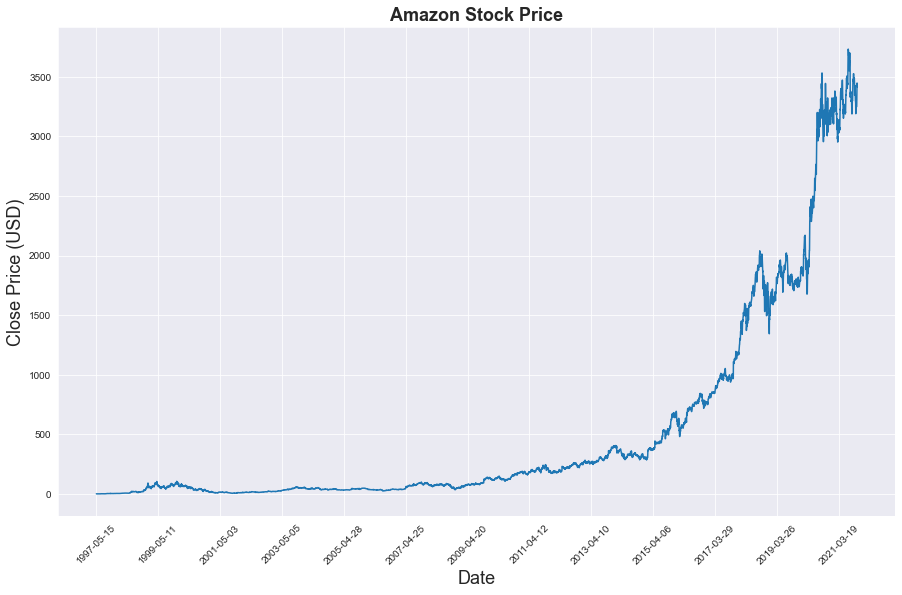

In [33]:
# Plot `data`
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.title("Amazon Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [34]:
# Clean the data (dropping may not be necessary since there is already reordering on line 13)
# Remove date
data.drop(['Date'], 1, inplace=True)

# Drop Dividends if the entire column is 0, since it causes zero divided by zero during normalization
data.drop(['Dividends'], 1, inplace=True)

# Dropping Stock Splits, because although stock splits can be very telling of the rise/fall of a stock price,
# there seem to be too many 0 values and the trade-off isn't worth it
data.drop(['Stock Splits'], 1, inplace=True)

# Reorder the columns
data = data[['Open', 'High', 'Low', 'Volume', 'Close']]

C:\Users\le2ma\AppData\Local\Temp/ipykernel_12740/1567801331.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(['Date'], 1, inplace=True)
C:\Users\le2ma\AppData\Local\Temp/ipykernel_12740/1567801331.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(['Dividends'], 1, inplace=True)
C:\Users\le2ma\AppData\Local\Temp/ipykernel_12740/1567801331.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(['Stock Splits'], 1, inplace=True)


In [35]:
price = data[['Close']]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

# # Could also just use
# scaler = MinMaxScaler(feature_range=(-1, 1))
# data[['Close']] = scaler.fit(data[['Close']].values.reshape(-1,1))

C:\Users\le2ma\AppData\Local\Temp/ipykernel_12740/2947730558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [36]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [37]:
sequence_length = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, sequence_length)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (4904, 19, 1)
y_train.shape =  (4904, 1)
x_test.shape =  (1226, 19, 1)
y_test.shape =  (1226, 1)


In [40]:
%pip install torch==1.10.0+cu102 torchvision==0.11.1+cu102 torchaudio===0.10.0+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html

^C
Note: you may need to restart the kernel to use updated packages.
Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html


In [38]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

ModuleNotFoundError: No module named 'torch'

In [ ]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)